In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from model import FeatureDependentMarkovChain
from sklearn.preprocessing import QuantileTransformer
import networkx as nx

In [2]:
df = yf.download("JNJ")
df["RET"] = df["Adj Close"].pct_change()
df["RET1D"] = df.RET.shift(1).rolling(1).mean()
df["RET5D"] = df.RET.shift(1).rolling(5).mean()
df["RET20D"] = df.RET.shift(1).rolling(20).mean()
df["RET60D"] = df.RET.shift(1).rolling(60).mean()
vix = yf.download("^VIX")["Adj Close"].shift(1)
df["VIX"] = vix[df.index]
# df["Volume"] = df.Volume * df["Adj Close"]
df["Volume60D"] = df.Volume.shift(1).rolling(60).mean()
df = df[df.index >= "2000"]
df.index

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-16',
               '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-22',
               '2021-02-23', '2021-02-24'],
              dtype='datetime64[ns]', name='Date', length=5320, freq=None)

In [3]:
n = 5

qt = QuantileTransformer()

train_size = 3000
val_size = 1000

volume = df.Volume.values[:, None]
volume_train = volume[:train_size]
volume_val = volume[train_size:train_size+val_size]
volume_test = volume[train_size+val_size:]
volume_train = qt.fit_transform(volume_train).flatten()
volume_val = qt.transform(volume_val).flatten()
volume_test = qt.transform(volume_test).flatten()
s_train = list(np.digitize(volume_train, np.linspace(0, 1+1e-8, n+1)) - 1)
s_val = list(np.digitize(volume_val, np.linspace(0, 1+1e-8, n+1)) - 1)
s_test = list(np.digitize(volume_test, np.linspace(0, 1+1e-8, n+1)) - 1)

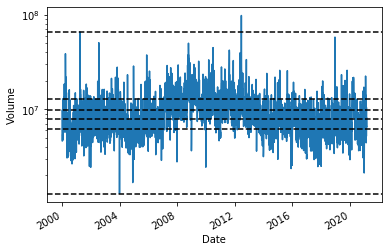

In [4]:
df.Volume.plot()
plt.semilogy()
plt.ylabel("Volume")
for x in qt.inverse_transform(np.linspace(0, 1, n+1)[:,None]):
    plt.axhline(x, ls='--', c='black')
plt.savefig("figs/volume.pdf")

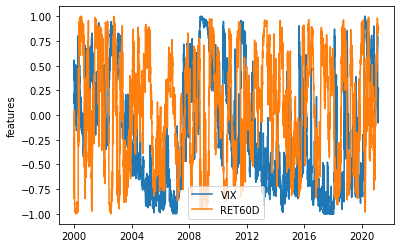

In [5]:
features = df[["VIX", "RET60D"]].values
features = np.hstack([features])
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')
features_train = features[:train_size]
features_val = features[train_size:train_size+val_size]
features_test = features[train_size+val_size:]
features_train = (scaler.fit_transform(features_train) - .5) * 2
features_val = (scaler.transform(features_val) - .5) * 2
features_test = (scaler.transform(features_test) - .5) * 2
plt.plot(df.index, np.concatenate([features_train[:,0], features_val[:,0], features_test[:,0]]), label='VIX')
plt.plot(df.index, np.concatenate([features_train[:,1], features_val[:,1], features_test[:,1]]), label='RET60D')
plt.ylabel("features")
plt.savefig("figs/features.pdf")
plt.legend()

In [6]:
np.set_printoptions(precision=8, suppress=True)
P = np.zeros((n, n))
for i in range(len(s_train) - 1):
    P[s_train[i], s_train[i+1]] += 1
P /= P.sum(axis=1)[:,None]
np.round(P, 2)

array([[0.56, 0.27, 0.11, 0.04, 0.02],
       [0.3 , 0.35, 0.21, 0.1 , 0.04],
       [0.1 , 0.24, 0.32, 0.24, 0.1 ],
       [0.03, 0.12, 0.25, 0.35, 0.26],
       [0.01, 0.02, 0.11, 0.28, 0.59]])

In [7]:
len(s_train), len(s_val), len(s_test)

(3000, 1000, 1320)

In [8]:
from copy import deepcopy
s_train_missing = deepcopy(s_train)

In [9]:
df.index[train_size:train_size+val_size]

DatetimeIndex(['2011-12-05', '2011-12-06', '2011-12-07', '2011-12-08',
               '2011-12-09', '2011-12-12', '2011-12-13', '2011-12-14',
               '2011-12-15', '2011-12-16',
               ...
               '2015-11-11', '2015-11-12', '2015-11-13', '2015-11-16',
               '2015-11-17', '2015-11-18', '2015-11-19', '2015-11-20',
               '2015-11-23', '2015-11-24'],
              dtype='datetime64[ns]', name='Date', length=1000, freq=None)

In [10]:
np.random.seed(0)
for idx in np.random.choice(np.arange(1, len(s_train) - 1), 750, replace=False):
    s_train_missing[idx] = np.nan

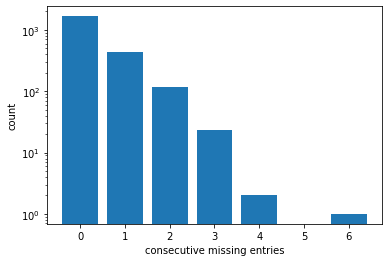

In [11]:
i = 0
len_nan = []
while i < len(s_train) - 1:
    if ~np.isnan(s_train_missing[i]) and ~np.isnan(s_train_missing[i+1]):
        i += 1
        len_nan.append(0)
    else:
        j = 1
        while np.isnan(s_train_missing[i+j]):
            j += 1
        i += j
        len_nan.append(j - 1) 
q = pd.value_counts(np.array(len_nan))
plt.bar(q.index, q)
plt.semilogy()
plt.xlabel("consecutive missing entries")
plt.ylabel("count")
plt.savefig("figs/consecutive.pdf")

In [18]:
z = np.linspace(0,1,n+1)

def evaluate(zero_features=False, verbose=False, missing=True, average=False, **kwargs):
    model = FeatureDependentMarkovChain(n, **kwargs)
    if missing:
        s = s_train_missing
    else:
        s = s_train
    if zero_features:
        model.fit(s, features_train * 0, [len(s_train)], verbose=verbose)
        train_ll = model.score(s, features_train * 0, [len(s_train)], average=average)
        val_ll = model.score(s_val, features_val * 0, [len(s_val)], average=average)
        test_ll = model.score(s_test, features_test * 0, [len(s_test)], average=average)
        pred = model.predict(features_test * 0)[np.arange(len(s_test) - 1),s_test[:-1],:]
    else:
        model.fit(s, features_train, [len(s_train)], verbose=verbose)
        train_ll = model.score(s, features_train, [len(s_train)], average=average)
        val_ll = model.score(s_val, features_val, [len(s_val)], average=average)
        test_ll = model.score(s_test, features_test, [len(s_test)], average=average)
        pred = model.predict(features_test)[np.arange(len(s_test) - 1),s_test[:-1],:]
    pred_median = []
    for i in range(len(pred)):
        pred_median.append(np.interp(.5, np.cumsum(np.append(0, pred[i])), z))
    pred_score = np.mean(np.abs(volume_test[1:] - np.array(pred_median)))
    return model, train_ll, val_ll, test_ll, pred_score

## Fitting without missing data

In [32]:
W_lap_states = nx.adjacency_matrix(nx.path_graph(5))

model1, train1, val1, test1, pred1 = evaluate(zero_features=True, verbose=False, missing=False, lam_frob=0, n_iter=1)
model2, train2, val2, test2, pred2 = None, -float("inf"), -float("inf"), -float("inf"), float("inf")
for lam_lap in np.logspace(-5, 0, 25):
    modeli, traini, vali, testi, predi = evaluate(zero_features=True, verbose=False, missing=False,
                                           lam_frob=0, n_iter=1, W_lap_states=lam_lap * W_lap_states)
    if vali > val2:
        model2, train2, val2, test2, pred2 = modeli, traini, vali, testi, predi

model3, train3, val3, test3, pred3 = None, -float("inf"), -float("inf"), -float("inf"), float("inf")
for lam_frob in np.logspace(-5, 0, 25):
    modeli, traini, vali, testi, predi = evaluate(zero_features=False, verbose=False, missing=False,
                                           lam_frob=lam_frob, n_iter=1)
    if vali > val3:
        model3, train3, val3, test3, pred3 = modeli, traini, vali, testi, predi

model4, train4, val4, test4, pred4 = None, -float("inf"), -float("inf"), -float("inf"), float("inf")
best_lam = None
for lam_frob in np.logspace(-5, 0, 10): 
    for lam_lap in np.logspace(-5, 0, 10):
        modeli, traini, vali, testi, predi = evaluate(zero_features=False, verbose=False, missing=False,
                                                   lam_frob=lam_frob, n_iter=1, W_lap_states=lam_lap * W_lap_states)
        if vali > val4:
            model4, train4, val4, test4, pred4 = modeli, traini, vali, testi, predi
            best_lam= (lam_frob, lam_lap)

In [33]:
print("Empirical & %.3f & %.3f & %.3f & %.4f \\\\" % (train1, val1, test1, pred1))
print("Constant Lap-reg & %.3f & %.3f & %.3f & %.4f \\\\" % (train2, val2, test2, pred2))
print("Feature-dependent & %.3f & %.3f & %.3f & %.4f \\\\" % (train3, val3, test3, pred3))
print("Feature-dependent Lap-reg & %.3f & %.3f & %.3f & %.4f \\\\" % (train4, val4, test4, pred4))

Empirical & -3900.401 & -1371.396 & -1691.016 & 0.1679 \\
Constant Lap-reg & -3900.575 & -1371.324 & -1690.136 & 0.1680 \\
Feature-dependent & -3827.929 & -1352.177 & -1669.247 & 0.1627 \\
Feature-dependent Lap-reg & -3829.225 & -1351.480 & -1662.247 & 0.1624 \\


## Fitting with missing data

In [34]:
W_lap_states = nx.adjacency_matrix(nx.path_graph(5))

model5, train5, val5, test5, pred5 = evaluate(zero_features=True, verbose=False, missing=True, lam_frob=0, n_iter=1)
model6, train6, val6, test6, pred6 = evaluate(zero_features=True, verbose=False, missing=True, lam_frob=0, n_iter=20)
model7, train7, val7, test7, pred7 = None, -float("inf"), -float("inf"), -float("inf"), float("inf")
for lam_lap in np.logspace(-5, -1, 10):
    modeli, traini, vali, testi, predi = evaluate(zero_features=True, verbose=False, missing=True,
                                           lam_frob=0, n_iter=20, W_lap_states=lam_lap * W_lap_states)
    if vali > val7:
        model7, train7, val7, test7, pred7 = modeli, traini, vali, testi, predi

model8, train8, val8, test8, pred8 = None, -float("inf"), -float("inf"), -float("inf"), float("inf")
for lam_frob in np.logspace(-5, 0, 10):
    modeli, traini, vali, testi, predi = evaluate(zero_features=False, verbose=False, missing=True,
                                           lam_frob=lam_frob, n_iter=1)
    if vali > val8:
        model8, train8, val8, test8, pred8 = modeli, traini, vali, testi, predi
    
model9, train9, val9, test9, pred9 = None, -float("inf"), -float("inf"), -float("inf"), float("inf")
best_lam = None
for lam_frob in np.logspace(-5, 0, 10):
    modeli, traini, vali, testi, predi = evaluate(zero_features=False, verbose=False, missing=True,
                                           lam_frob=lam_frob, n_iter=20)
    if vali > val9:
        model9, train9, val9, test9, pred9 = modeli, traini, vali, testi, predi
        best_lam = lam_frob

model10, train10, val10, test10, pred10 = None, -float("inf"), -float("inf"), -float("inf"), float("inf")
for lam_lap in np.logspace(-5, -1, 10):
    modeli, traini, vali, testi, predi = evaluate(zero_features=False, verbose=False, missing=True,
                                               lam_frob=best_lam, n_iter=20, W_lap_states=lam_lap * W_lap_states)
    if vali > val10:
        model10, train10, val10, test10, pred10 = modeli, traini, vali, testi, predi

In [35]:
print("Constant & %.3f & %.3f & %.3f & %.4f \\\\" % (train5, val5, test5, pred5))
print("Constant EM & %.3f & %.3f & %.3f & %.4f \\\\" % (train6, val6, test6, pred6))
print("Constant EM Lap-Reg & %.3f & %.3f & %.3f & %.4f \\\\" % (train7, val7, test7, pred7))
print("Feature-dependent & %.3f & %.3f & %.3f & %.4f \\\\" % (train8, val8, test8, pred8))
print("Feature-dependent EM & %.3f & %.3f & %.3f & %.4f \\\\" % (train9, val9, test9, pred9))
print("Feature-dependent EM Lap-reg & %.3f & %.3f & %.3f & %.4f \\\\" % (train10, val10, test10, pred10))

Constant & -2147.901 & -1382.040 & -1692.203 & 0.1671 \\
Constant EM & -2150.172 & -1376.034 & -1697.146 & 0.1670 \\
Constant EM Lap-Reg & -2150.942 & -1373.591 & -1688.555 & 0.1677 \\
Feature-dependent & -2098.477 & -1357.371 & -1668.068 & 0.1603 \\
Feature-dependent EM & -2103.031 & -1353.012 & -1673.706 & 0.1607 \\
Feature-dependent EM Lap-reg & -2106.992 & -1349.184 & -1659.219 & 0.1611 \\


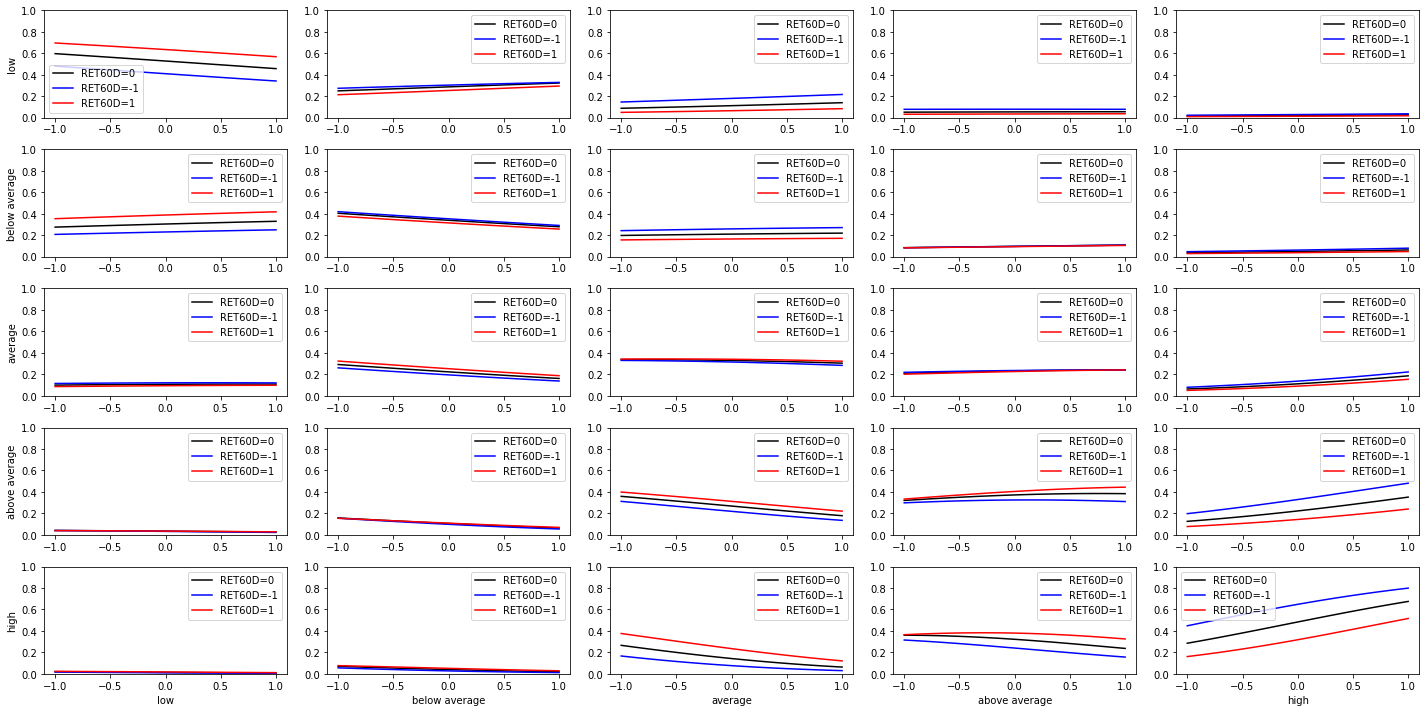

In [36]:
features_fake = np.zeros((100, features.shape[1]))
features_fake[:, 0] = np.linspace(-1, 1, 100)
Ps1 = model10.predict(features_fake)
features_fake = np.ones((100, features.shape[1])) * -1
features_fake[:, 0] = np.linspace(-1, 1, 100)
Ps2 = model10.predict(features_fake)
features_fake = np.ones((100, features.shape[1])) * 1
features_fake[:, 0] = np.linspace(-1, 1, 100)
Ps3 = model10.predict(features_fake)

fig, axes = plt.subplots(n, n, figsize=(20, 10))
for i in range(n):
    for j in range(n):
        axes[i, j].plot(features_fake[:, 0], Ps1[:,i,j], c='k', label='RET60D=0')
        axes[i, j].set_ylim(0, 1)
for i in range(n):
    for j in range(n):
        axes[i, j].plot(features_fake[:, 0], Ps2[:,i,j], c='blue', label='RET60D=-1')
for i in range(n):
    for j in range(n):
        axes[i, j].plot(features_fake[:, 0], Ps3[:,i,j], c='red', label='RET60D=1')
        axes[i, j].legend()

for i, c in enumerate(["low", "below average", "average", "above average", "high"]):
    axes[i, 0].set_ylabel(c)
    axes[-1, i].set_xlabel(c)
plt.tight_layout()
plt.savefig("figs/varying_vix.pdf")
plt.show()

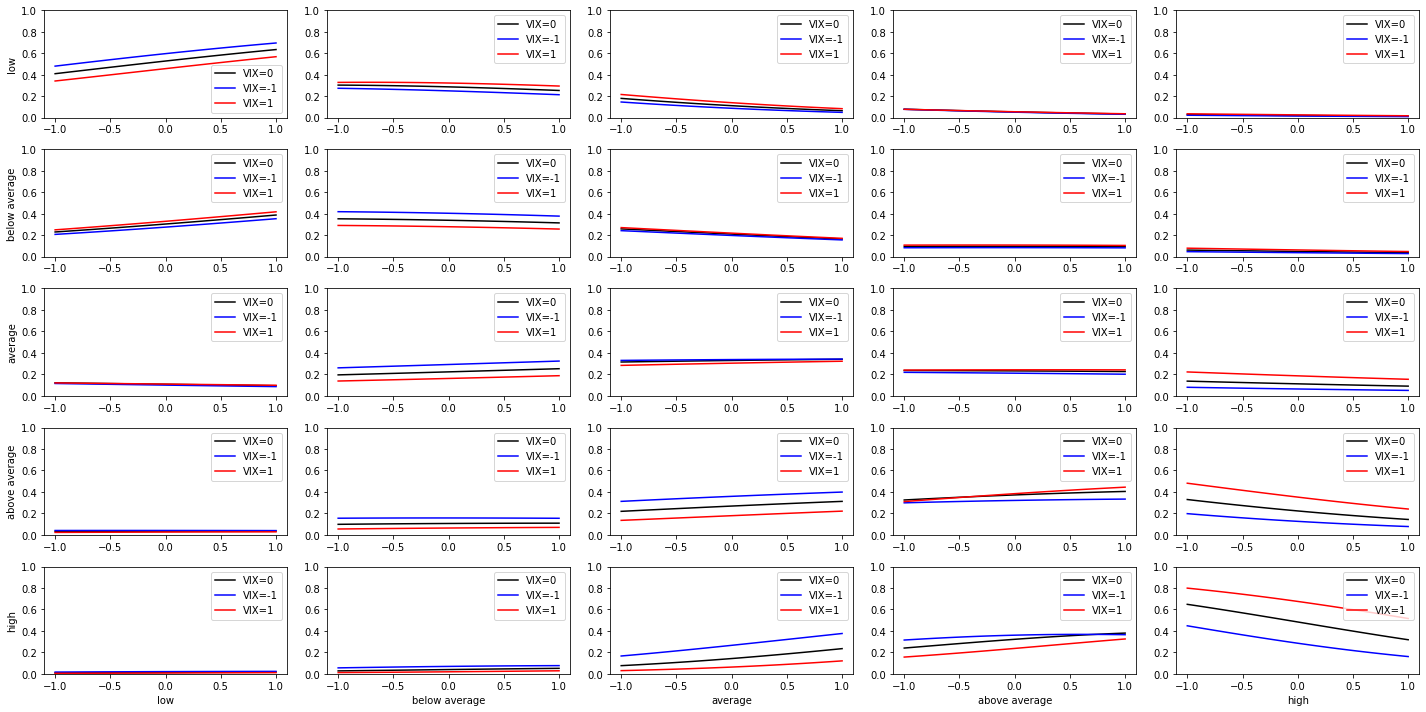

In [37]:
features_fake = np.zeros((100, features.shape[1]))
features_fake[:, 1] = np.linspace(-1, 1, 100)
Ps1 = model10.predict(features_fake)
features_fake = np.ones((100, features.shape[1])) * -1
features_fake[:, 1] = np.linspace(-1, 1, 100)
Ps2 = model10.predict(features_fake)
features_fake = np.ones((100, features.shape[1])) * 1
features_fake[:, 1] = np.linspace(-1, 1, 100)
Ps3 = model10.predict(features_fake)

fig, axes = plt.subplots(n, n, figsize=(20, 10))
for i in range(n):
    for j in range(n):
        axes[i, j].plot(features_fake[:, 1], Ps1[:,i,j], c='k', label='VIX=0')
        axes[i, j].set_ylim(0, 1)
for i in range(n):
    for j in range(n):
        axes[i, j].plot(features_fake[:, 1], Ps2[:,i,j], c='blue', label='VIX=-1')
for i in range(n):
    for j in range(n):
        axes[i, j].plot(features_fake[:, 1], Ps3[:,i,j], c='red', label='VIX=1')
        axes[i, j].legend()

for i, c in enumerate(["low", "below average", "average", "above average", "high"]):
    axes[i, 0].set_ylabel(c)
    axes[-1, i].set_xlabel(c)
plt.tight_layout()
plt.savefig("figs/varying_ret60d.pdf")
plt.show()

In [38]:
num = 20
features_fake = np.zeros((num * num, features.shape[1]))
x1 = np.linspace(-1, 1, num)
x2 = np.linspace(-1, 1, num)
for i in range(num):
    for j in range(num):
        features_fake[i + j * num, 0] = x1[i]
        features_fake[i + j * num, 1] = x2[j]

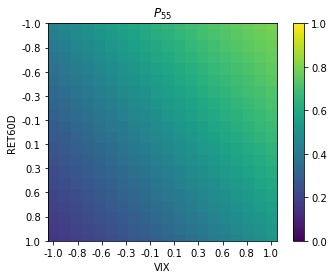

In [39]:
Ps = model10.predict(features_fake)
plt.imshow(Ps[:, 4, 4].reshape(num, num), vmin=0, vmax=1)
plt.xlabel("VIX")
plt.ylabel("RET60D")
plt.xticks(np.linspace(0, num-1, num //2), np.round(np.linspace(-1,1,num // 2), 1))
plt.yticks(np.linspace(0, num-1, num //2), np.round(np.linspace(-1,1,num // 2), 1))
plt.title("$P_{55}$")
plt.colorbar()
plt.savefig("figs/P_55.pdf")

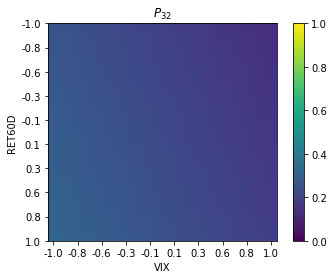

In [40]:
Ps = model10.predict(features_fake)
plt.imshow(Ps[:, 2, 1].reshape(num, num), vmin=0, vmax=1)
plt.xlabel("VIX")
plt.ylabel("RET60D")
plt.xticks(np.linspace(0, num-1, num //2), np.round(np.linspace(-1,1,num // 2), 1))
plt.yticks(np.linspace(0, num-1, num //2), np.round(np.linspace(-1,1,num // 2), 1))
plt.title("$P_{32}$")
plt.colorbar()
plt.savefig("figs/P_32.pdf")